# ResNet编程实现
<img src="my_files/resnet.png" style="width:800px;height:600px;">

In [70]:
import numpy as np
from keras import layers
from keras.layers import Input,ZeroPadding2D,Conv2D,BatchNormalization,Activation,MaxPooling2D,AveragePooling2D,Flatten,Dense

from keras.layers import Add

from keras.models import Model,load_model
# axvier
from keras.initializers import glorot_uniform

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

import tensorflow as tf


import keras.backend as K
K.set_image_data_format('channels_last')


from resnets_utils import load_dataset,convert_to_one_hot



from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import scipy
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline


### 1 identity_block

In [2]:
def identity_block(X,f,filters,stage,block):
    """
    构建identity block    
    conv_name_base
    

    Parameters
    ----------
    X : 输入 tensor tf.placeholder类型，shape=(m,n_H_prev,n_W_prev,n_C_prev) 
    f:  中间层window大小
    filters: list of int，filters个数
    stage: int 标识阶段
    block : str or int 用来起名字

    Returns
    -------
    X :  
     
    """    
    conv_name="res_{}_{}_branch".format(stage,block)
    bn_name="bn_{}_{}_branch".format(stage,block)
    
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(F1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2a')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2a')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2b')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2b')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2c')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2c')(X)
    
    X=Add()([X_shortcut,X])    
    X=Activation('relu')(X)
    
    return X    

#### 【bug】`You must feed a value for placeholder tensor `
```
InvalidArgumentError: You must feed a value for placeholder tensor 'bn_1_block_a_branch2a/keras_learning_phase' with dtype bool
	 [[Node: bn_1_block_a_branch2a/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: activation_3/Relu/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_260_activation_3/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

During handling of the above exception, another exception occurred:

InvalidArgumentErrorTraceback (most recent call last)
<ipython-input-21-26b9a51b5766> in <module>()
      7     A=identity_block(A_prev,2,filters=[2,4,6],stage=1,block='a')
      8     test.run(tf.global_variables_initializer())
----> 9     out=test.run([A],feed_dict={A_prev:X})
     10     print(out)
     11 
```
- 解决方案：设置 `K.learning_phase():0`，直观理解，就是一定要指定`learning_phase 参数`(区分是test 还是train)
```
import keras.backend as K
out=test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
```

```
learning_phase
keras.backend.learning_phase()
Returns the learning phase flag.

The learning phase flag is a bool tensor (0 = test, 1 = train) to be passed as input to any Keras function that uses a different behavior at train time and test time.

Returns

Learning phase (scalar integer tensor or Python integer).
```



In [3]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev=tf.placeholder(tf.float32,shape=[3,4,5,6],name='A_prev')
    X=np.random.randn(3,4,5,6)
    A=identity_block(A_prev,2,filters=[2,4,6],stage=1,block='a')
    test.run(tf.global_variables_initializer())
    out=test.run([A],feed_dict={A_prev:X})
    print(out)
    
    
    
    
    


InvalidArgumentError: You must feed a value for placeholder tensor 'bn_1_a_branch2a/keras_learning_phase' with dtype bool
	 [[Node: bn_1_a_branch2a/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: activation_3/Relu/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_260_activation_3/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'bn_1_a_branch2a/keras_learning_phase', defined at:
  File "/home/jun.liang/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jun.liang/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/jun.liang/miniconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/jun.liang/miniconda3/lib/python3.6/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/jun.liang/miniconda3/lib/python3.6/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-26b9a51b5766>", line 7, in <module>
    A=identity_block(A_prev,2,filters=[2,4,6],stage=1,block='a')
  File "<ipython-input-2-76c6b680eeb5>", line 28, in identity_block
    X=BatchNormalization(axis=-1,name=bn_name+'2a')(X)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/keras/layers/normalization.py", line 190, in call
    training=training)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2610, in in_train_phase
    training = learning_phase()
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 115, in learning_phase
    name='keras_learning_phase')
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jun.liang/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'bn_1_a_branch2a/keras_learning_phase' with dtype bool
	 [[Node: bn_1_a_branch2a/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: activation_3/Relu/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_260_activation_3/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [4]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev=tf.placeholder(tf.float32,shape=[3,4,4,6],name='A_prev')
    X=np.random.randn(3,4,4,6)
    A=identity_block(A_prev,2,filters=[2,4,6],stage=1,block='a')
    test.run(tf.global_variables_initializer())
    out=test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))

out = [0.94822997 0.         1.1610144  2.747859   0.         1.36677   ]


### 2 convolutional_block

In [5]:
def convolutional_block(X,f,filters,stage,block,s=2):
    """
    构建 convolutional_block
    conv_name_base
    

    Parameters
    ----------
    X : 输入 tensor tf.placeholder类型，shape=(m,n_H_prev,n_W_prev,n_C_prev) 
    f:  中间层window大小
    filters: list of int，filters个数
    stage: int 标识阶段
    block : str or int 用来起名字
    s:strides for shortcut 

    Returns
    -------
    X :  
     
    """    
    conv_name="res_{}_{}_branch".format(stage,block)
    bn_name="bn_{}_{}_branch".format(stage,block)
    
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(F1,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2a')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2a')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2b')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2b')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2c')(X)
    X=BatchNormalization(axis=-1,name=bn_name+'2c')(X)
    
    X_shortcut=Conv2D(F3,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'1')(    X_shortcut)
    X_shortcut=BatchNormalization(axis=-1,name=bn_name+'1')(X_shortcut)    
    
    X=Add()([X_shortcut,X])    
    X=Activation('relu')(X)
    

    
    return X    

#### 【bug】`ValueError: Operands could not be broadcast together with shapes (2, 2, 6) (4, 4, 6)`

```
ValueError    Traceback (most recent call last)
<ipython-input-47-6127dcc90209> in <module>()
      5     A_prev = tf.placeholder("float", [3, 4, 4, 6])
      6     X = np.random.randn(3, 4, 4, 6)
----> 7     A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
      8     test.run(tf.global_variables_initializer())
      9     out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})

<ipython-input-46-03d4fa87f849> in convolutional_block(X, f, filters, stage, block, s)
     40     X_shortcut=BatchNormalization(axis=-1,name=bn_name+'1')(X_shortcut)
     41 
---> 42     X=Add()([X_shortcut,X])
     43     X=Activation('relu')(X)
     44 
```

- 原因分析： 第一层的stride要进行修改

```
    X=Conv2D(F1,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer=glorot_uniform(seed=0),name=conv_name+'2a')(X)

```


In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018461 1.2348977  0.46822017 0.0367176  0.         0.65516603]


### 3 构建模型-搭建一个50层的Resnet
- 实际项目中，要先将模型结构细节确定下来，再决定搭建


- 模型初始化上的差异：
    - convolutional_block 和 identity_block 就需要指定输入的X
    - ResNet50时直接用`Input`层，指定shape就可以了

```
    X_input = Input(input_shape)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

```
<img src="my_files/resnet50.png" style="width:800px;height:400px;">   
   
   
- FC层就是在 dense + activation    

In [7]:
def ResNet50(input_shape=(64,64,3),classes=6):
    X_input=Input(shape=input_shape)
    
    X=ZeroPadding2D(padding=(3,3))(X_input)
    
    X=Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='valid',name='conv1')(X)
    X=BatchNormalization(axis=-1,name='bn1')(X)
    X=Activation('relu')(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=convolutional_block(X,f=3,filters=[64,64,256],stage=2,block='a',s=1)
    X=identity_block(X,f=3,filters=[64,64,256],stage=2,block='b')
    X=identity_block(X,f=3,filters=[64,64,256],stage=2,block='c')    
    
    X=convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    X=identity_block(X,f=3,filters=[128,128,512],stage=3,block='b')
    X=identity_block(X,f=3,filters=[128,128,512],stage=3,block='c')    
    X=identity_block(X,f=3,filters=[128,128,512],stage=3,block='d')        
    
    X=convolutional_block(X,f=3,filters=[256, 256, 1024],stage=4,block='a',s=2)
    X=identity_block(X,f=3,filters=[256, 256, 1024],stage=4,block='b')
    X=identity_block(X,f=3,filters=[256, 256, 1024],stage=4,block='c')    
    X=identity_block(X,f=3,filters=[256, 256, 1024],stage=4,block='d')        
    X=identity_block(X,f=3,filters=[256, 256, 1024],stage=4,block='e')        
    X=identity_block(X,f=3,filters=[256, 256, 1024],stage=4,block='f')            
    

    X=convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X=identity_block(X,f=3,filters=[512,512,2048],stage=5,block='b')
    X=identity_block(X,f=3,filters=[512,512,2048],stage=5,block='c')    
    
    X=AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',name='fc{}'.format(classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    model=Model(inputs=X_input,outputs=X,name='ResNet50')
    
    return model


In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)



In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn1 (BatchNormalization)         (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

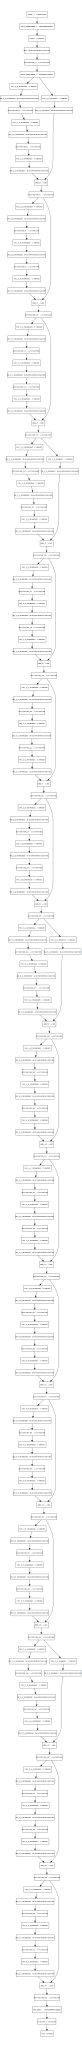

In [11]:
plot_model(model, to_file='ResNet50.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [15]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 4s - loss: 2.2475 - acc: 0.3944     
Epoch 2/2
1080/1080 [==============================] - 2s - loss: 1.1928 - acc: 0.6907     


In [16]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s     
Loss = 2.3868598620096844
Test Accuracy = 0.16666666716337203


In [158]:
model.fit(X_train, Y_train, epochs =20 , batch_size = 32)

Epoch 1/20
1080/1080 [==============================] - 3s - loss: 0.0127 - acc: 0.9944     
Epoch 2/20
1080/1080 [==============================] - 2s - loss: 0.0125 - acc: 0.9954     
Epoch 3/20
1080/1080 [==============================] - 2s - loss: 0.0048 - acc: 0.9991     
Epoch 4/20
1080/1080 [==============================] - 2s - loss: 0.0108 - acc: 0.9981     
Epoch 5/20
1080/1080 [==============================] - 2s - loss: 0.0023 - acc: 1.0000     
Epoch 6/20
1080/1080 [==============================] - 2s - loss: 0.0015 - acc: 1.0000     
Epoch 7/20
1080/1080 [==============================] - 2s - loss: 7.6781e-04 - acc: 1.0000     
Epoch 8/20
1080/1080 [==============================] - 2s - loss: 3.3653e-04 - acc: 1.0000     
Epoch 9/20
1080/1080 [==============================] - 2s - loss: 2.5811e-04 - acc: 1.0000     
Epoch 10/20
1080/1080 [==============================] - 3s - loss: 2.9958e-04 - acc: 1.0000     
Epoch 11/20
1080/1080 [==============================

In [159]:
preds = model.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1080/1080 [==============================] - 0s     
Loss = 0.049520091643487966
Test Accuracy = 0.9842592592592593


In [160]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s     
Loss = 0.14821952084700266
Test Accuracy = 0.9416666706403096


In [161]:
model.save("my_model.h5")

#### 【bug】准确率很高，但是结果不正确啊
- 有可能有过拟合导致的，在预测集效果不是很好

y=2
[[2.3735475e-04 2.7099231e-02 9.7252685e-01 6.1933275e-07 1.3192299e-04
  4.0655214e-06]]
2


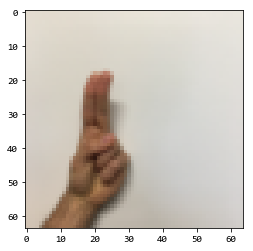

In [162]:
index=10
plt.imshow(X_train_orig[index])
print("y={}".format(np.squeeze(Y_train_orig[:,index])))

prediction=model.predict(X_train[index:index+1])
print(prediction)
print(np.argmax(prediction))


---------
y=3
[[2.0725400e-05 1.4337831e-10 6.7494161e-09 9.9996054e-01 1.3300827e-05
  5.4700504e-06]]
3


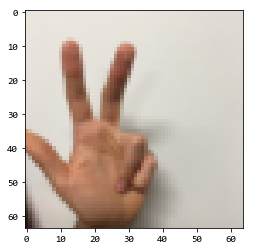


---------
y=2
[[2.0426653e-04 1.5746921e-04 9.9880612e-01 4.9189985e-05 7.8194198e-04
  1.0528938e-06]]
2


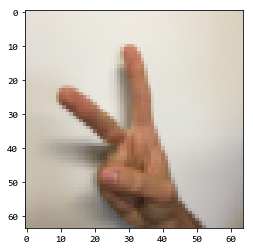


---------
y=0
[[1.0000000e+00 2.2598983e-36 1.5466036e-31 9.4385716e-37 1.7147608e-20
  2.3156371e-35]]
0


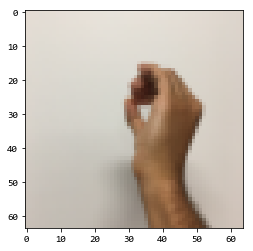


---------
y=5
[[1.6688723e-07 8.4707831e-12 1.9503538e-11 6.2309127e-08 4.0980833e-04
  9.9958998e-01]]
5


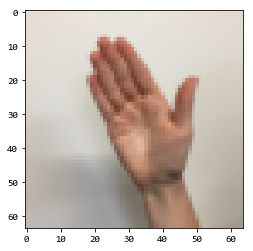


---------
y=5
[[2.5949072e-05 2.2964434e-08 9.5705772e-08 5.5054030e-03 3.7122949e-03
  9.9075621e-01]]
5


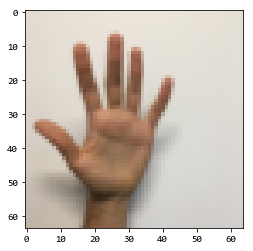


---------
y=5
[[4.6437042e-04 2.4318673e-04 5.4981564e-03 6.7844987e-03 1.4330514e-03
  9.8557681e-01]]
5


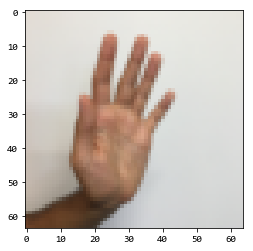


---------
y=5
[[1.2226133e-08 1.3089190e-11 2.3666552e-10 1.0288978e-08 1.4857191e-04
  9.9985147e-01]]
5


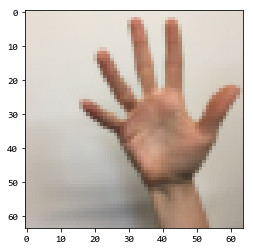


---------
y=3
[[1.2960057e-03 1.8324945e-06 1.0889145e-05 9.9865508e-01 1.2712187e-07
  3.6064041e-05]]
3


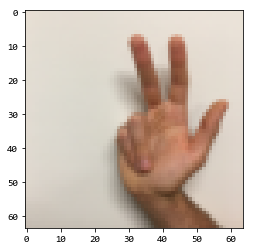


---------
y=0
[[1.0000000e+00 3.5383892e-23 3.9977399e-18 4.7652027e-23 2.0780415e-12
  8.6477463e-23]]
0


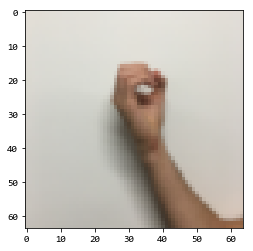


---------
y=2
[[1.8260190e-04 3.8140675e-03 9.5625985e-01 1.5317564e-06 3.9644785e-02
  9.7193108e-05]]
2


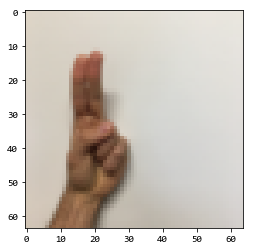


---------
y=4
[[5.4647622e-08 5.4336385e-10 1.9711997e-06 1.3391516e-08 9.9994135e-01
  5.6677731e-05]]
4


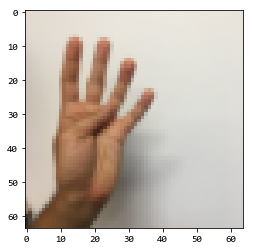


---------
y=0
[[1. 0. 0. 0. 0. 0.]]
0


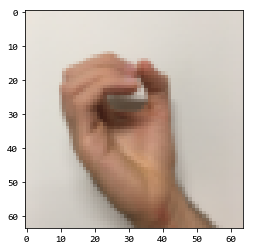


---------
y=3
[[3.4679845e-06 1.7514710e-11 4.3893513e-12 9.9998343e-01 6.1984196e-10
  1.3148337e-05]]
3


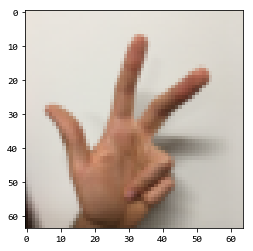


---------
y=0
[[1. 0. 0. 0. 0. 0.]]
0


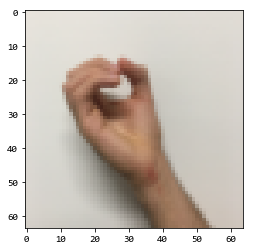


---------
y=2
[[4.0301204e-02 2.7574254e-03 1.6282437e-02 1.9985813e-04 9.4016635e-01
  2.9272560e-04]]
4


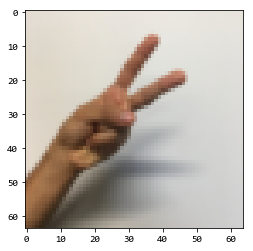


---------
y=4
[[3.9220989e-08 1.1849868e-11 6.2436449e-08 5.3565481e-07 9.9999094e-01
  8.5156043e-06]]
4


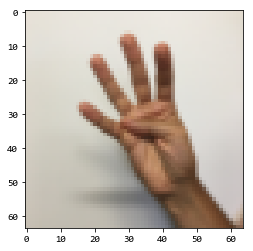


---------
y=4
[[6.9606250e-07 5.6506479e-09 9.5841767e-07 4.7024118e-05 9.9994993e-01
  1.4619072e-06]]
4


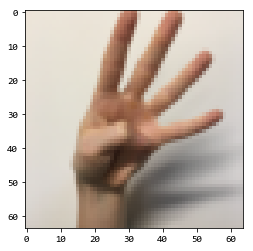


---------
y=0
[[1.0000000e+00 2.5902785e-18 1.5074227e-13 3.2840526e-17 2.5115615e-10
  6.8498754e-19]]
0


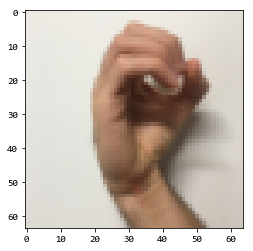


---------
y=4
[[5.21881098e-04 3.95086281e-05 1.01245154e-04 5.92943244e-02
  9.32169080e-01 7.87395705e-03]]
4


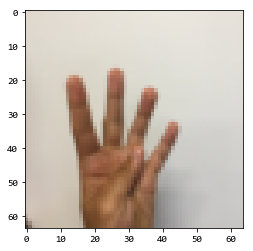


---------
y=4
[[1.7597024e-01 2.9803416e-01 1.9025493e-03 1.8602149e-01 3.3795822e-01
  1.1335353e-04]]
4


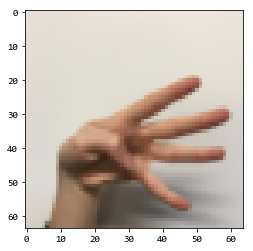

In [165]:
import random
for index in random.sample(range(len(Y_test)),20):
    plt.imshow(X_test_orig[index])
    print("\n---------\ny={}".format(np.squeeze(Y_test_orig[:,index])))

    prediction=model.predict(X_test[index:index+1])
    print(prediction)
    print(np.argmax(prediction))    
    plt.show()


Input image shape: (64, 64, 3)


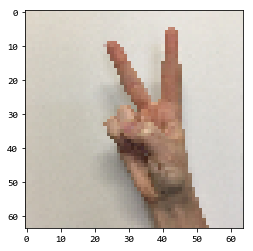

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[7.7610873e-03 8.8462597e-01 9.9965066e-02 1.1582908e-04 7.5304788e-03
  1.5997238e-06]]
1


In [164]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
print('Input image shape:', x.shape)
plt.imshow(np.uint8(x))
plt.show()

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
prediction=model.predict(x/255.0)
print(prediction)
print(np.argmax(prediction))

### 将课程提供模型load进来

In [55]:
trained_model = load_model('ResNet50.h5') 

In [152]:
preds = trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s     
Loss = 0.5301785389582316
Test Accuracy = 0.8666666746139526


Input image shape: (64, 64, 3)


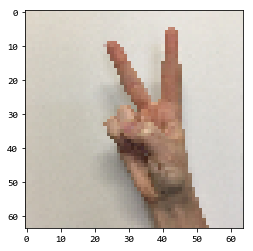

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[0.23859906 0.00402427 0.18809997 0.2918022  0.24764948 0.02982504]]
3


In [154]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
print('Input image shape:', x.shape)
plt.imshow(np.uint8(x))
plt.show()

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
prediction=trained_model.predict(x/255.0)
print(prediction)
print(np.argmax(prediction))

In [157]:
trained_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [166]:
pwd

'/data/jun.liang/jupyter_workspace/pengju/deep-learning-coursera-full/Convolutional Neural Networks/week2/ResNets'